<a href="https://colab.research.google.com/github/Vankadara-Naga-Vyshnavi/Machine-learning/blob/master/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import os
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
transform = transforms.Compose([   
     transforms.ToTensor(), 
     transforms.Normalize(mean=0,std=1) 
      ])  
train_dataset = FashionMNIST(train=True, transform=transform, root=os.getcwd(), download=True)
test_dataset = FashionMNIST(train=False, transform=transform, root=os.getcwd(), download=True)

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw
Processing...
Done!


In [4]:
print("Train dataset:", train_dataset)

Train dataset: Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /content
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0, std=1)
           )


In [5]:
print("Test dataset:", test_dataset)

Test dataset: Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /content
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0, std=1)
           )


In [0]:
train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True,num_workers=4)
test_loader = DataLoader(test_dataset,batch_size=16,shuffle=True,num_workers=4)

In [8]:
train_iterator = iter(train_loader)
train_batch = next(train_iterator)
for item in train_batch:
  print(item.size())

torch.Size([16, 1, 28, 28])
torch.Size([16])


In [0]:
def plot_images(batch):
  img_grid = make_grid(batch[0], nrow=4)
  img_np = img_grid.numpy()
  img_np = np.transpose(img_np,(1,2,0))
  plt.figure(figsize=(8,8))
  plt.imshow(img_np)
  plt.title(batch[1])
  plt.xticks([])
  plt.yticks([])
  plt.plot()


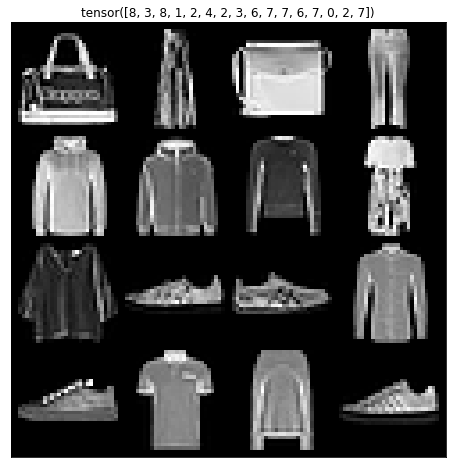

In [10]:
plot_images(train_batch)

In [11]:
flatten=nn.Flatten()
flatten(train_batch[0]).size()

torch.Size([16, 784])

In [12]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
    nn.Softmax(dim=1)
)
model

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=10, bias=True)
  (8): Softmax(dim=1)
)

In [13]:
pred_batch = model(train_batch[0])
print(pred_batch.size())

torch.Size([16, 10])


In [14]:
pred_lables = torch.argmax(pred_batch , axis=1)
print(pred_lables)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1],
       grad_fn=<NotImplemented>)


In [0]:
loss_criterian = nn.CrossEntropyLoss()

In [16]:
loss_criterian(pred_batch, train_batch[1])

tensor(2.3025, grad_fn=<NllLossBackward>)

In [0]:
def evaluate_on_cpu(model, dataloader):
  with torch.no_grad():
    total, correct = 0, 0
    for batch in dataloader:
      images, labels = batch
      out_probs = model(images)
      out_labels = torch.argmax(out_probs, axis=1)
      total += labels.size(0)
      correct += torch.sum(labels == out_labels).item()
    return 100 * correct/total
def train_on_cpu(model, loss_criterion, optimizer, train_loader, test_loader, epochs=250):
  hist = {'loss':[],
          'train_acc':[],
          'test_acc':[]}
  for epoch_num in tqdm (range(1,epochs+1), desc='Training', total=epochs):
    losses = []
    for batch in train_loader:
      images, labels = batch
      optimizer.zero_grad()
      out = model(images)
      loss = loss_criterion(out, labels)
      losses.append(loss.item())
      loss.backward()
      optimizer.step()
    hist['loss'].append(np.array(losses).mean())
    train_acc = evaluate_on_cpu(model, train_loader)
    test_acc = evaluate_on_cpu(model, test_loader)
    hist['train_acc'].append(train_acc)
    hist['test_acc'].append(test_acc)
  fig, ax = plt.subplots(nrow=1,ncols=2, figsize=(14,7))
  ax[0].plot(range(1, epochs+1),hist['loss'], label='loss')
  ax[0].grid()
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss Value')
  ax[0].set_title('Epochs vs. Loss')
  ax[1].plot(range(1, epochs+1), hist['train_acc'], 'b-', label='Training accuracy')
  ax[1].plot(range(1, epochs+1), hist['test_acc'], 'm-', label='Test accuracy')
  ax[1].grid()
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title('Epochs vs. Accuracy')
  plt.show()
  return model

In [20]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
model = train_on_cpu(model, loss_criterion, optimizer, train_loader, test_loader)

KeyboardInterrupt: ignored

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [0]:
def evaluate_on_gpu(model, dataloader):
  with torch.no_grad():
    total, correct = 0, 0
    for batch in dataloader:
      images, labels = batch
      images, labels = images.to(device), labels.to(device)
      out_probs = model(images)
      out_labels = torch.argmax(out_probs, axis=1)
      total += labels.size(0)
      correct += torch.sum(labels == out_labels).item()
    return 100 * correct/total
def train_on_gpu(model, loss_criterion, optimizer, train_loader, test_loader, epochs=250):
  hist = {'loss':[],
          'train_acc':[],
          'test_acc':[]}
  for epoch_num in tqdm (range(1,epochs+1), desc='Training', total=epochs):
    losses = []
    for batch in train_loader:
      images, labels = batch
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      out = model(images)
      loss = loss_criterion(out, labels)
      losses.append(loss.item())
      loss.backward()
      optimizer.step()
    hist['loss'].append(np.array(losses).mean())
    train_acc = evaluate_on_gpu(model, train_loader)
    test_acc = evaluate_on_gpu(model, test_loader)
    hist['train_acc'].append(train_acc)
    hist['test_acc'].append(test_acc)
  fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(14,7))
  ax[0].plot(range(1, epochs+1),hist['loss'], label='Loss')
  ax[0].grid()
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss Value')
  ax[0].set_title('Epochs vs. Loss')
  ax[1].plot(hist['train_acc'], 'b-', label='Training accuracy')
  ax[1].plot(hist['test_acc'], 'm-', label='Test accuracy')
  ax[1].grid()
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title('Epochs vs. Accuracy')
  plt.show()
  return model

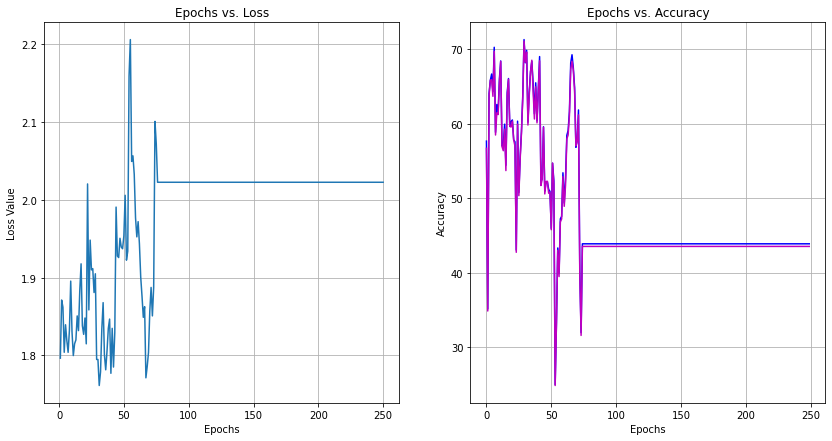

In [19]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),7
    nn.Linear(in_features=256, out_features=10),
    nn.Softmax(dim=1)
)
model = model.to(device)
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
model = train_on_gpu(model, loss_criterion, optimizer, train_loader, test_loader)